# Data Loading

In [4]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Data Pre-processing

In [6]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [7]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [8]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [9]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
final = final.iloc[0:10000]
scores = final['Score']

# Split the Data Set into train and test

In [13]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================
#supress warnings
warnings.filterwarnings("ignore")

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_1 = y_1.values


# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


# Hyper Parameter tuning using GridSearchCV

In [14]:
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

#function to find optimal n_estimators
def findGridSearchCVBestParameters(x_tr,y_tr):

    parameters = {'n_estimators':[10,20,40,60,80,100,200,300,1000]}
    gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=parameters,scoring = 'accuracy', cv=5)
    gridmodel.fit(x_tr, y_tr)
    grid_best_params = gridmodel.best_estimator_
    gridmodel_best_score = gridmodel.best_score_
    return grid_best_params,gridmodel_best_score

# RandomForestClassifier

In [15]:
#function to apply RandomForestClassifier model
def applyRandomForestClassifierModel(x_tr,y_tr,e):
    classifier= RandomForestClassifier(n_estimators=e)
    classifier.fit(x_tr, y_tr)
    return classifier

# Finding Accuracy

In [16]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.svm import SVC

#fucntion to get Test and Train Accuracy details
def getAccuracyReport(x_tr,x_test,y_tr,y_test,e):
    classifier = applyRandomForestClassifierModel(x_tr,y_tr,e)
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test, y_pred))
    print('Training accuracy:', classifier.score(x_tr, y_tr))
    print('Test accuracy:', classifier.score(x_test, y_test))
    cm = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(cm, annot=True,annot_kws={"size": 16})

# BOW Featurization

In [17]:
#supress warnings
warnings.filterwarnings("ignore")

#Converting text to vector(BOW)
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_tr)
X_tr_vector_bow = count_vect.transform(X_tr)
X_test_vector_bow = count_vect.transform(X_test)

# Optimal number of estimators

In [18]:
gridsearch_best_params_bow,gridsearch_best_score_bow = findGridSearchCVBestParameters(X_tr_vector_bow,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_bow)
print('Grid Search Best Score:\n',gridsearch_best_score_bow)

Grid Search Best Params:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Grid Search Best Score:
 0.8991836734693878


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.84      0.13      0.23       320
   positive       0.91      1.00      0.95      2680

avg / total       0.90      0.91      0.87      3000

Training accuracy: 0.9997959183673469
Test accuracy: 0.905


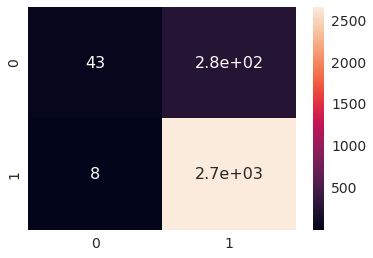

In [39]:
getAccuracyReport(X_tr_vector_bow,X_test_vector_bow,y_tr, y_test,80)

# Important Features

In [46]:
bow_rclf = applyRandomForestClassifierModel(X_tr_vector_bow,y_tr,80)
importances = bow_rclf.feature_importances_ 
feature_names =count_vect.get_feature_names() 
imp = sorted(zip(importances, feature_names),reverse=True)[:20] 
for imortance,feature in imp:    
    print(imortance,feature)

0.010986224114514675 horribl
0.00951768607852128 disappoint
0.00695415326333325 great
0.006938091594634603 worst
0.006525166964847726 aw
0.004839835402473582 bad
0.0046708724754582365 love
0.004638831153180507 poor
0.004470372009224978 return
0.00434661724184083 terribl
0.004297656739473124 best
0.00424285503120409 tast
0.004214472120690775 refund
0.003972802748412782 disgust
0.003857444071513008 gross
0.003850813067271632 product
0.0037386123604021063 like
0.0037159878063991064 hope
0.003686256654004462 threw
0.0036120969844126542 order


# TFIDF Featurization

In [20]:
#Converting text to tfidf vector(tfidf)
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit(X_tr)
X_tr_vector_tfidf = final_tf_idf.transform(X_tr)
X_test_vector_tfidf = final_tf_idf.transform(X_test)

# Optimal numbers of estimator

In [21]:
gridsearch_best_params_tfidf,gridsearch_best_score_tfidf = findGridSearchCVBestParameters(X_tr_vector_tfidf,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_tfidf)
print('Grid Search Best Score:\n',gridsearch_best_score_tfidf)

Grid Search Best Params:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Grid Search Best Score:
 0.893265306122449


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.61      0.21      0.31       320
   positive       0.91      0.98      0.95      2680

avg / total       0.88      0.90      0.88      3000

Training accuracy: 0.993061224489796
Test accuracy: 0.9013333333333333


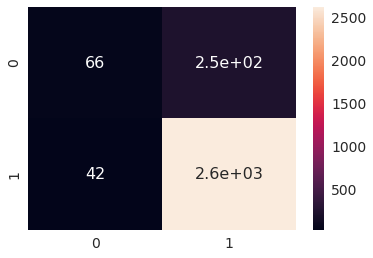

In [22]:
getAccuracyReport(X_tr_vector_tfidf,X_test_vector_tfidf,y_tr, y_test,10)

# Important Features

In [51]:
tfidf_rclf = applyRandomForestClassifierModel(X_tr_vector_tfidf,y_tr,10)
importances = tfidf_rclf.feature_importances_ 
feature_names =count_vect.get_feature_names() 
imp = sorted(zip(importances, feature_names),reverse=True)[:20] 
for imortance,feature in imp:    
    print(imortance,feature)

0.013635978672693746 aw
0.011408719133709961 disappoint
0.009841699903220244 poor
0.008682659454293098 horribl
0.007371525388774178 great
0.006124343044558536 look
0.005520162393406086 threw
0.005308499823650678 love
0.005067786952784033 hope
0.004829070851170196 like
0.004737315962662339 refund
0.004608665760923052 receiv
0.004442171863505533 tast
0.004375125767577627 worth
0.004300762085591323 didnt
0.004161086524151767 wast
0.004095552521629893 bland
0.004047209684648723 gross
0.003970489347875193 credit
0.003924767057528738 product


# AVGW2V Featurization

In [23]:
import gensim
import warnings
#supress warning
warnings.filterwarnings("ignore") 
i=0
list_of_sent_X_tr=[]
for sent in X_tr:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_tr.append(filtered_sentence)

In [24]:
import gensim

#supress warnings
warnings.filterwarnings("ignore")

i=0
list_of_sent_X_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_test.append(filtered_sentence)

In [25]:
w2v_model=gensim.models.Word2Vec(list_of_sent_X_tr,min_count=1,size=50, workers=4) 

In [26]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_tr.append(sent_vec)

In [27]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_test.append(sent_vec)

In [28]:
X_tr_vector_avgW2V = sent_vectors_X_tr
X_test_vector_avgW2V = sent_vectors_X_test 

In [29]:
from sklearn.preprocessing import Imputer
X_test_vector_avgW2V = Imputer().fit_transform(X_test_vector_avgW2V)

# Optimal numbers of estimator

In [30]:
gridsearch_best_params_avgW2v,gridsearch_best_score_avgW2V = findGridSearchCVBestParameters(X_tr_vector_avgW2V,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_avgW2v)
print('Grid Search Best Score:\n',gridsearch_best_score_avgW2V)

Grid Search Best Params:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Grid Search Best Score:
 0.8820408163265306


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.39      0.03      0.05       320
   positive       0.90      0.99      0.94      2680

avg / total       0.84      0.89      0.85      3000

Training accuracy: 1.0
Test accuracy: 0.8916666666666667


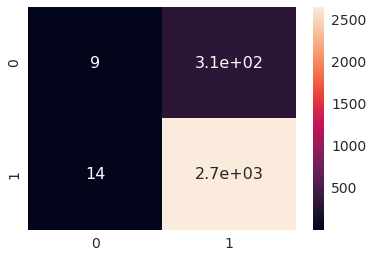

In [40]:
getAccuracyReport(X_tr_vector_avgW2V,X_test_vector_avgW2V,y_tr, y_test,40)

# Important Features

In [52]:
avgW2v_rclf = applyRandomForestClassifierModel(X_tr_vector_avgW2V,y_tr,40)
importances = avgW2v_rclf.feature_importances_ 
feature_names =count_vect.get_feature_names() 
imp = sorted(zip(importances, feature_names),reverse=True)[:20] 
for imortance,feature in imp:    
    print(imortance,feature)

0.027390362790322774 accentu
0.026878997260023373 aaaaah
0.024744455068829847 ab
0.02443869403235703 access
0.024263299952381447 accompani
0.024164520164970144 acacia
0.02345251032023248 accommod
0.023406877989707666 abandon
0.02338738597686745 absorb
0.023295188076648064 absolu
0.023109670846093413 abund
0.021944128705738863 abouyt
0.021436678928533695 acclam
0.02136729601572942 accredit
0.021354959144708793 abstract
0.02134341156106654 abil
0.021118296862879384 abus
0.020466190323500166 accur
0.019974069557864446 accept
0.019955208185125188 account


# TFIDFW2Vec Featurization

In [32]:
tf_idf_X_tr_vect = TfidfVectorizer()
tf_idf_X_tr_vect.fit(X_tr)
final_tf_idf_X_tr_vect = tf_idf_X_tr_vect.transform(X_tr)
final_tf_idf_X_test_vect = tf_idf_X_tr_vect.transform(X_test)

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_tr_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try: 
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_tr_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_tr_vectors.append(sent_vec)
    row += 1

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_test_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_test_vectors.append(sent_vec)
    row += 1

In [35]:
from sklearn.preprocessing import Imputer
X_tr_vector_tfidfW2V = tfidf_sent_X_tr_vectors
X_test_vector_tfidfW2V = tfidf_sent_X_test_vectors
X_tr_vector = Imputer().fit_transform(X_tr_vector_tfidfW2V)
X_test_vector = Imputer().fit_transform(X_test_vector_tfidfW2V)

# Optimal numbers of estimator

In [36]:
gridsearch_best_params_tfidfW2V,gridsearch_best_score_tfidfW2V = findGridSearchCVBestParameters(X_tr_vector_tfidfW2V,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_tfidfW2V)
print('Grid Search Best Score:\n',gridsearch_best_score_tfidfW2V)

Grid Search Best Params:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Grid Search Best Score:
 0.8820408163265306


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.33      0.02      0.04       320
   positive       0.89      1.00      0.94      2680

avg / total       0.83      0.89      0.85      3000

Training accuracy: 1.0
Test accuracy: 0.8913333333333333


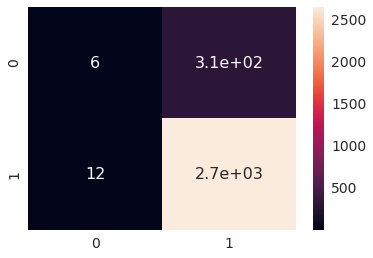

In [43]:
getAccuracyReport(X_tr_vector_tfidfW2V,X_test_vector_tfidfW2V,y_tr, y_test,200)

# Important Features

In [54]:
tfidfW2v_rclf = applyRandomForestClassifierModel(X_tr_vector_tfidfW2V,y_tr,200)
importances = tfidfW2v_rclf.feature_importances_
words = w2v_model.wv.index2word
imp = sorted(zip(importances, words),reverse=True)[:10]
for imortance,feature in imp:
    print(imortance,feature)

0.028835395179269314 amazon
0.02624428923796903 tea
0.026072082447104798 realli
0.02495518541590678 like
0.023251046223441117 year
0.023212400479292544 well
0.023015924841213772 bag
0.022776516240076514 littl
0.022720393623794223 recommend
0.02228354496657602 eat


# Conclusion

In [12]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Featurization', 'Optimal_n_Estimator','Train Error','Test Error']
t.add_row(["BOW","80","0.00020408163","0.095"])
t.add_row(["TFIDF","10","0.00693877551","0.09866666666"])
t.add_row(["AVGW2V","40","0","0.10833333333"])
t.add_row(["TFIDFW2V","200","0","0.10866666666"])
print(t)

+---------------+---------------------+---------------+---------------+
| Featurization | Optimal_n_Estimator |  Train Error  |   Test Error  |
+---------------+---------------------+---------------+---------------+
|      BOW      |          80         | 0.00020408163 |     0.095     |
|     TFIDF     |          10         | 0.00693877551 | 0.09866666666 |
|     AVGW2V    |          40         |       0       | 0.10833333333 |
|    TFIDFW2V   |         200         |       0       | 0.10866666666 |
+---------------+---------------------+---------------+---------------+
